# Challenge: Get the best results on the [fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset!

> "Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits."

<img src="https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png">




## TASK - Challenge: Get the best results on the fashionMNIST dataset!

The challenge of this task is to get the best results on the fashionMNIST dataset by tuning hyperparameters of the model and observing convergence behavior.

"Best" - for simplicity - means the highest accuracy on the validation set.

"Rules":

    You can change any hyperparameters,
    including the number of layers,
    width of the layers,
    activation functions,
    regularizers (and their parameters),
    optimizer (and it's parameters), but
    you should not change the model architecture, use only fully connected layers! (Even if you know any others... :-P

Added constraint: The model with the "best performance" has to be saved, so it should not be just a printout happening once during training!

And: You may NOT manipulate the validation set! :-P

Happy coding! :-)


# Loading the data

In [ ]:
! wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
! wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
! wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
! wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2020-10-12 10:09:11--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.178
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.74.178|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M   104MB/s    in 0.2s    

2020-10-12 10:09:11 (104 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2020-10-12 10:09:11--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.178
Connecting to fashion-mnist.s3-website.eu-central-1.amazo

In [ ]:
import numpy as np
import os
import gzip

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`.
    """
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
train_images, train_labels = load_mnist('.')
# because of some limitations of Keras's softmax implementation, it's 
# advisable to normalise the images by dividing the intensities by the
# maximal 255 value
train_images = train_images / 255.

valid_test_images, valid_test_labels = load_mnist('.', 't10k')

valid_test_images = valid_test_images / 255. # the same normalization for valid and test

valid_images = valid_test_images[:5000]
valid_labels = valid_test_labels[:5000]
test_images = valid_test_images[5000:]
test_labels = valid_test_labels[5000:]

print(train_images.shape, valid_images.shape, test_images.shape)

(60000, 784) (5000, 784) (5000, 784)


Let's have a look at the first few training images:

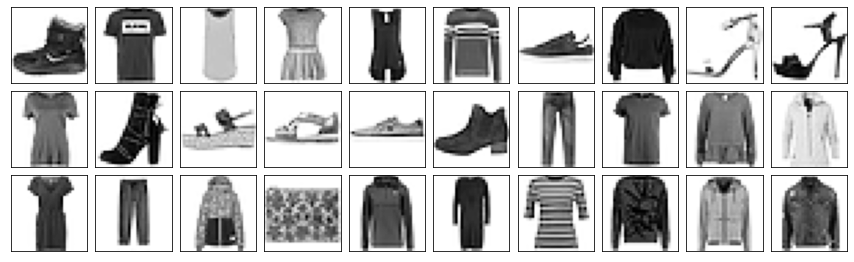

In [ ]:
from matplotlib import pyplot as plt
from math import ceil

def show_images(images):
    """Show images in a grid
    """
    n_rows = ceil(len(images) / 10)
    fig, ax = plt.subplots(n_rows, 10, figsize=(15, 1.5 * n_rows),
                           subplot_kw={'xticks':[], 'yticks':[]},
                           gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, _ in enumerate(images):
        # below we scale back the intensities to display the images correctly
        ax[i // 10, i % 10].imshow(255 * images[i].reshape(28, 28), cmap='Greys')

show_images(train_images[:30])
plt.show();

# Model

## Preliminaries

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta, Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.regularizers import l1
from tensorflow.keras.backend import clear_session

We set the random seeds to get (as far as possible) reproducible results:

In [ ]:
# Fix seeds for (hopefully) reproducible results
from numpy.random import seed
seed(300)
tf.random.set_seed(300)

## Hyperparameters

In [ ]:
# Task parameters

input_size = 784
n_classes = 10

# Hyperparameters
#################

# dropout??? or no dropout???
dropout_rate = 0.1

# regularization
lambda_ = 0.0001
regularizer = l1(lambda_)
# regularizer = None 

# weight initialization
initializer = "he_uniform"
# Warning! 
##########
# Possible bug in Keras Initalizers!
# When stuck, use RandomUniform or RandomNormal!

# Model parameters
#################

# hidden_layers
hidden_layer_size = 32
n_hidden_layers   = 3
hidden_layer_sizes = n_hidden_layers * [hidden_layer_size]

# activation function
activation_fun =  "relu"

## Network

In [ ]:
tf.compat.v1.reset_default_graph() # It's good practice to clean and reset everything
clear_session            # even using Keras


# Model
#######

#Define input with input_size (achtung, vector! :-)
inputs = Input((input_size,))

# Hidden layers

cur_last_layer = n_hidden_layers

# Construct a for loop going over the values of hidden_layer_sizes
# using cur_last_layer as pointer
# build up the network layer by layer
# use the parameters units, activation, kernel_regularizer, kernel_initializer, bias_initializer
# Add a dopout layer after each one WHEN PARAMETER SET!
# Remember, dropout is a separate layer, use dropout_rate as parameter
layer = inputs
for l in range(cur_last_layer):
    layer = Dense(units=hidden_layer_size, activation = activation_fun,kernel_initializer=initializer,bias_initializer='zeros',
                  kernel_regularizer=regularizer)(layer)
    layer = Dropout(dropout_rate)(layer)



# Softmax 
#Define the predictions!
#Use Softmax!
predictions = Dense(units=n_classes,activation = 'softmax')(layer)

# Full model
# Instantiate with input and output
model = Model(inputs,predictions)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)               

## Loss, optimization and compilation

In [ ]:
# Loss 

loss = sparse_categorical_crossentropy # we use this cross entropy variant as the input is not 
                                       # one-hot encoded

# Optimizer

optimizer = Adam(learning_rate=0.01)#??? some SGD variant 
 
# Compilation
#############
#Compile with optimizer and loss, use accuracy as metric
model.compile(optimizer= optimizer,
              loss='sparse_categorical_crossentropy', # use this cross entropy variant
                                                      # since the input is not one-hot encoded
              metrics=['accuracy']) #We measure and print accuracy during training

## Training

### Let's train the model on GPU
- List the devices and put it in training with GPU
- Manage the session to run

In [ ]:
from keras.utils import multi_gpu_model
from tensorflow.python.client import device_lib
import tensorflow as tf
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15885743011941479132
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10141949629051003074
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8100148420378887887
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11146783616
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10765558699089785145
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [ ]:
with tf.device('/gpu:0'):
    history = model.fit(x=train_images, y=train_labels,
                        validation_data=(valid_images, valid_labels),
                        epochs=20,
                        batch_size=128)

Epoch 1/20
469/469 [==============================] - 2s 4ms/step - loss: 0.9141 - accuracy: 0.7024 - val_loss: 0.6319 - val_accuracy: 0.8116
Epoch 2/20
469/469 [==============================] - 2s 4ms/step - loss: 0.7340 - accuracy: 0.7735 - val_loss: 0.6259 - val_accuracy: 0.8118
Epoch 3/20
469/469 [==============================] - 2s 4ms/step - loss: 0.7144 - accuracy: 0.7847 - val_loss: 0.6655 - val_accuracy: 0.8054
Epoch 4/20
469/469 [==============================] - 2s 4ms/step - loss: 0.7115 - accuracy: 0.7865 - val_loss: 0.6137 - val_accuracy: 0.8218
Epoch 5/20
469/469 [==============================] - 2s 4ms/step - loss: 0.7198 - accuracy: 0.7875 - val_loss: 0.6633 - val_accuracy: 0.7860
Epoch 6/20
469/469 [==============================] - 2s 4ms/step - loss: 0.7092 - accuracy: 0.7918 - val_loss: 0.6137 - val_accuracy: 0.8266
Epoch 7/20
469/469 [==============================] - 2s 4ms/step - loss: 0.7044 - accuracy: 0.7929 - val_loss: 0.6400 - val_accuracy: 0.8226
Epoch 

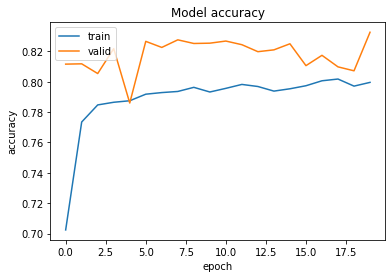

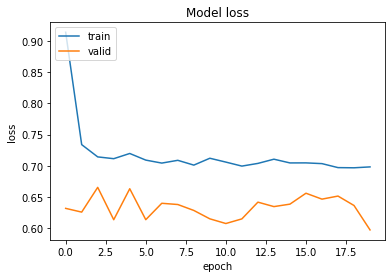

In [ ]:
def display_history(history):
    """Summarize history for accuracy and loss.
    """
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
#If you need...
display_history(history)

In [ ]:
# Get over this - minimally!!!!!
assert max(history.history['accuracy'])>0.72
assert max(history.history['val_accuracy'])>0.73

## Saving the model

In [ ]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
